In [113]:
import numpy as np
import pandas as pd
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import defaultdict
import pickle

In [114]:
epochs = 20 # data partition (important for the dataset construction)

In [115]:
def adjust_entropy(prob_distribution, temperature):
    temperature = max(1e-3, temperature)
    scaled_probs = np.power(prob_distribution, 1 / temperature)
    adjusted_distribution = scaled_probs / np.sum(scaled_probs)

    return adjusted_distribution


In [116]:
def min_max_scaling_numpy(data, new_min=1, new_max=10):
    if data.size == 0:
        return data
    original_min = np.min(data)
    original_max = np.max(data)

    if original_min == original_max or new_min == new_max:
        return data
    scaled_data = ((data - original_min) / (original_max - original_min)) * (new_max - new_min) + new_min
    
    return scaled_data

In [117]:
def shannon_diversity_index(true_likes):
    true_likes_sorted = np.sort(true_likes)[::-1]
    _, like_counts = np.unique(true_likes_sorted, return_counts=True)
    like_proportions = like_counts / np.sum(like_counts)
    return -np.sum(like_proportions * np.log(like_proportions))

In [118]:
def simpson_diversity_index(true_likes):
    true_likes_sorted = np.sort(true_likes)[::-1]
    _, like_counts = np.unique(true_likes_sorted, return_counts=True)
    like_proportions = like_counts / np.sum(like_counts)
    return np.sum(like_proportions ** 2)

In [119]:
def summary_func(likes):
    return np.mean(likes == 1), \
        likes.max() / np.sum(likes), \
            shannon_diversity_index(likes), \
                simpson_diversity_index(likes), \
                    np.mean(likes), \
                        np.median(likes)

In [120]:
df = pd.read_csv('data_/words_translations.csv')
df.shape

(54314, 10)

In [121]:
df = (df.
      pipe(lambda df: df[~df['rating'].isna()]).
      pipe(lambda df: df[df['rating'] > 0]).
      pipe(lambda df: df.assign(translation_created_at=pd.to_datetime(df['translation_created_at']))).
      pipe(lambda df: df.assign(word_created_at=pd.to_datetime(df['word_created_at']))).
      # create 100 bins (pd.date_rae(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs))
      pipe(lambda df: df.assign(bin=pd.cut(df['translation_created_at'], bins=epochs, labels=range(epochs)))).
      pipe(lambda df: df[~df['bin'].isna()]).
      pipe(lambda df: df.assign(word_n_words=df['word_body'].str.split().str.len())).
      pipe(lambda df: df[df['word_n_words'] == 1]).
      pipe(lambda df: df.assign(translation_n_words=df['translation_body'].str.split().str.len())).
      # only keep translations with 1 word
      pipe(lambda df: df[df['translation_n_words'] == 1]).
      # compute lengths in characters for each translation
      pipe(lambda df: df.assign(translation_len=df['translation_body'].str.len())).
      pipe(lambda df: df.assign(word_len=df['word_body'].str.len())).
      pipe(lambda df: df[df['translation_len'] > 1]).
      pipe(lambda df: df[df['word_len'] > 1])
).dropna()

In [122]:
# table with n of unique words and translations per bin
df_unique = df.groupby('bin').agg({'word_id': 'nunique', 'translation_id': 'nunique'}).reset_index()
df_unique.columns = ['bin', 'n_words', 'n_translations']

In [123]:
df_unique.shape

(20, 3)

Correlation:  0.38571711596459896


(0.0, 30.0)

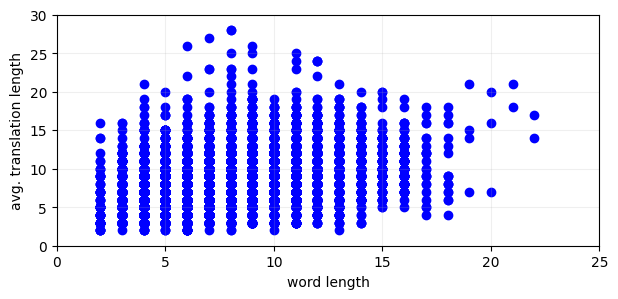

In [124]:
plt.figure(figsize=(7, 3))
plt.grid(alpha=0.2)
plt.scatter(x = df['word_len'], y = df['translation_len'], alpha=1, color = 'blue')
plt.xlabel('word length')
plt.ylabel('avg. translation length')
# print correlation
print('Correlation: ', np.corrcoef(df['word_len'], df['translation_len'])[0, 1])
plt.xlim(0, 25)
plt.ylim(0, 30)

In [125]:
votes = pd.read_csv("data_/votes.csv")
votes['created_at'] = pd.to_datetime(votes['created_at'])
# votes['bin'] = pd.cut(votes['created_at'], bins=epochs, labels=range(epochs))
# use datettime from df to create identical bins ('translation_created_at') and label then with range(epochs)
votes['bin'] = pd.cut(votes['created_at'], bins=pd.date_range(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs+1), labels=range(epochs))
votes = votes[~votes['bin'].isna()]

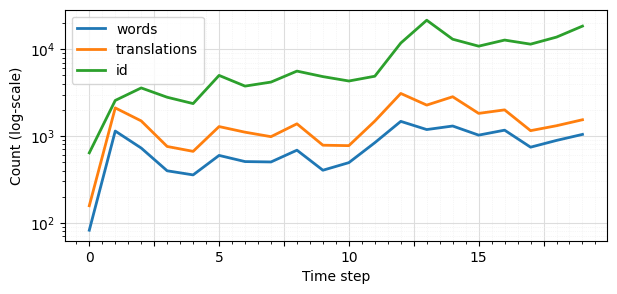

In [126]:
fig, ax = plt.subplots(figsize=(7, 3))
df_unique.plot(x='bin', y='n_words', ax=ax, label = 'words', linewidth=2)
df_unique.plot(x='bin', y='n_translations', ax=ax, label = 'translations', linewidth=2)
votes.groupby('bin').agg({'id': 'nunique'}).plot(ax=ax, label = 'votes', linewidth=2)
ax.set_yscale('log')
plt.xlabel('Time step')
plt.ylabel('Count (log-scale)')
plt.grid()
plt.legend()
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
plt.show()

In [127]:
# votes should have the same translations as df
votes = votes[votes['translation_id'].isin(df['translation_id'])]
# group by bin and user and count the number of votes
votes_ = votes.groupby(['bin', 'user_id']).size().reset_index(name='votes')
# for each bin, get the list of values in the column 'votes'
votes_ = votes_.query('votes > 0')
votes_ = votes_.groupby('bin')['votes'].apply(list).reset_index(name='votes')

In [128]:
votes_ = votes_.set_index('bin')['votes'].to_dict()
n_words = df_unique['n_words'].to_numpy().round().astype(int)
n_translations = df_unique['n_translations'].to_numpy().astype(int)
translation_len = df['translation_len'].to_numpy().astype(int)

In [129]:
with open('data/n_words.pkl', 'wb') as f:
    pickle.dump(n_words, f)

with open('data/n_translations.pkl', 'wb') as f:
    pickle.dump(n_translations, f)

with open('data/votes.pkl', 'wb') as f:
    pickle.dump(votes_, f)

with open('data/translation_len.pkl', 'wb') as f:
    pickle.dump(translation_len, f)

In [130]:
class SlovotvirModel:

    def __init__(self, 
                 words_series, 
                 translation_series, 
                 length_distr, 
                 votes_user, 
                 a, 
                 b,
                 temp):
        self.words_series = words_series
        self.translation_series = translation_series
        self.length_distr = length_distr
        self.votes_user = votes_user

        self.a = a
        self.b = b
        self.temp = temp

        self.n_epochs = len(self.words_series)

        self.word_pool = defaultdict(list)
        self.translation_pool = defaultdict(dict)
                    
    def like_prob(self, 
                  lengths, 
                  likes):
        probs = (1/lengths) ** self.a + likes ** self.b
        return probs / probs.sum()

    def process_epoch(self, 
                      epoch):
        n_words = self.words_series[epoch]
        n_translations = self.translation_series[epoch]
        n_votes = self.votes_user[epoch]

        [self.word_pool[np.random.randint(0, 1000000)] for _ in range(n_words)]

        unique_words = list(self.word_pool.keys())

        for _ in range(n_translations):
            word_id = np.random.choice(unique_words)
            translation_id = np.random.randint(0, 1000000)
            self.word_pool[word_id].append(translation_id)
            self.translation_pool[translation_id] = {'length': np.random.choice(self.length_distr), 
                                                     'likes': 1}

        likes_w = np.array([sum([self.translation_pool[translation_id]['likes'] for translation_id in 
                                 self.word_pool[word_id]]) for word_id in unique_words])

        likes_w = adjust_entropy(likes_w / likes_w.sum(), temperature=self.temp)

        for n in n_votes:
            for _ in range(n):
                translations = self.word_pool[np.random.choice(unique_words, p=likes_w)]

                while not translations:
                    translations = self.word_pool[np.random.choice(unique_words, p=likes_w)]

                lengths = np.array([self.translation_pool[translation_id]['length'] 
                                    for translation_id in translations]).astype(float)
                likes = np.array([self.translation_pool[translation_id]['likes'] 
                                  for translation_id in translations]).astype(float)
                
                if len(likes) == 1:
                    tr = translations[0]
                else:
                    probs = self.like_prob(min_max_scaling_numpy(lengths), 
                                           min_max_scaling_numpy(likes))
                    tr = np.random.choice(translations, p=probs)
                
                self.translation_pool[tr]['likes'] += 1

    def run(self):
        for epoch in tqdm.trange(self.n_epochs, 
                                 bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}',
                                 desc='Running the model', 
                                 position=0, 
                                 leave=True):
            self.process_epoch(epoch)

In [131]:
def run_model_(a, b, temp, abc = False):
    model = SlovotvirModel(n_words,
                            n_translations,
                            translation_len,
                            votes_,
                            a=a,
                            b=b,
                            temp=temp)

    model.run()

    likes = np.array([model.translation_pool[tr]['likes'] for tr in model.translation_pool.keys()]) 
    ranked = np.argsort(likes)[::-1]

    if abc:
        return summary_func(likes)
    return likes[ranked]

In [132]:
true_likes = df['rating'].to_numpy()
true_ranked = np.argsort(true_likes)[::-1]

In [133]:
summary_func(true_likes)

(0.32061805890873973,
 0.003006273294783502,
 2.2647409282566704,
 0.17316506921539174,
 4.497275298337587,
 2.0)

In [134]:
print(run_model_(a=0.5, b=0.5, temp=1, abc=True))

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

(0.34571009020348226, 0.001709564664760089, 2.440354848520041, 0.16929574537819173, 5.501363541011118, 2.0)


In [135]:
print(run_model_(a=0, b=0, temp=1, abc=True))

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

(0.293753929993712, 0.0009141986477478335, 2.502504438601722, 0.14488335802337232, 5.502515195975686, 3.0)


In [136]:
print(run_model_(a=5, b=0, temp=1.1, abc=True))

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

(0.25340189596669815, 0.0009023034154090548, 2.5573371605340216, 0.12650410053054126, 5.505124707034666, 3.0)


In [138]:
runs = []
for _ in range(10):
    runs.append(run_model_(a=10, b=0, temp=1))

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

In [139]:
# frequency bias

runs_ = []
for _ in range(10):
    runs_.append(run_model_(a=0, b=10, temp=1))

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

In [140]:
# unbiased

runs_u = []
for _ in range(10):
    runs_u.append(run_model_(a=0, b=0, temp=1))

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

In [155]:
# unbiased

runs_u = []
for _ in range(10):
    runs_u.append(run_model_(a=0, b=0, temp=10))

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

Running the model:   0%|                              | 0/20 [00:00<?, ?it/s]

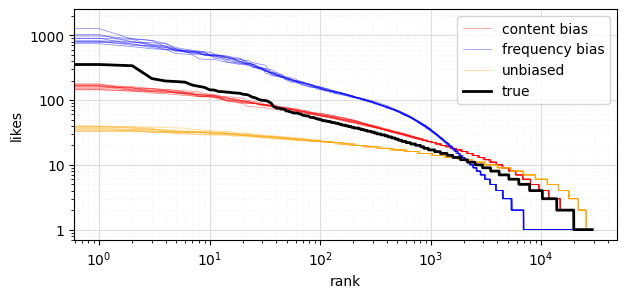

In [161]:
# plot runs
fig, ax = plt.subplots(figsize=(7, 3))
for run in runs:
    ax.plot(range(len(run)), run, color='red', alpha=0.5, label = 'content bias', linewidth=0.5)
for run in runs_:
    ax.plot(range(len(run)), run, color='blue', alpha=0.5, label = 'frequency bias', linewidth=0.5)
for run in runs_u:
    ax.plot(range(len(run)), run, color='orange', alpha=0.5, label = 'unbiased', linewidth=0.5)
ax.plot(range(len(true_likes[true_ranked])), true_likes[true_ranked], 
        color='black', label='true', alpha = 1, linewidth=2)
ax.set_xlabel('rank')
ax.set_ylabel('likes')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xscale('log')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
plt.show()

In [162]:
def plot_rank_segment(runs, runs_, low, high):
    fig, ax = plt.subplots(figsize=(7, 3))
    for run in runs:
        ax.plot(range(low, high), run[low:high], color='red', alpha=0.5, label='content bias')
    for run in runs_:
        ax.plot(range(low, high), run[low:high], color='blue', alpha=0.5, label='frequency bias')
    for run in runs_u:
        ax.plot(range(low, high), run[low:high], color='orange', alpha=0.5, label='unbiased')
    ax.set_xlabel('rank')
    ax.set_ylabel('likes')
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    plt.show()

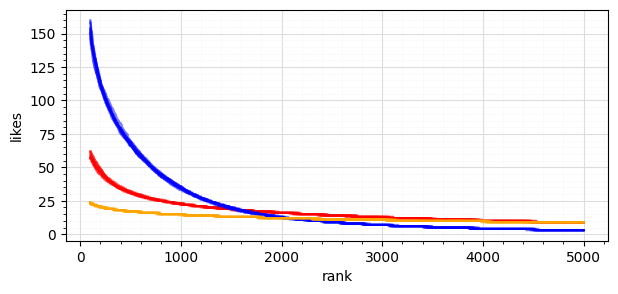

In [163]:
plot_rank_segment(runs, runs_, 100, 5000)